In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
from PIL import Image
import os
from sklearn import metrics
import glob
from joblib  import dump
import pickle

In [2]:
df=pd.read_csv("data_imu_birlestirilmis_28_10.csv")

In [3]:
df

,Unnamed: 0,ax,ay,az,gx,gy,gz,timestamp,time_diff,Class Name
0,0,-1.028198,7.406667,-2.838919,-0.418559,0.063694,0.027297,1900-01-01 17:55:40.747,NaN,not_falling
1,1,-1.020539,7.627713,-2.904742,-0.430347,0.050697,0.045961,1900-01-01 17:55:40.767,0 days 00:00:00.020000,not_falling
2,2,-1.013342,7.828984,-2.935427,-0.440230,0.041012,0.059841,1900-01-01 17:55:40.787,0 days 00:00:00.020000,not_falling
3,3,-1.003664,7.984988,-2.912928,-0.446552,0.034748,0.066260,1900-01-01 17:55:40.807,0 days 00:00:00.020000,not_falling
4,4,-0.980148,8.063047,-2.868723,-0.448961,0.024543,0.068392,1900-01-01 17:55:40.827,0 days 00:00:00.020000,not_falling
...,...,...,...,...,...,...,...,...,...,...
49731,49731,1.828079,9.423597,-0.645419,-1.292857,-0.038149,-2.056477,1900-01-01 17:50:02.385999,0 days 00:00:00.019999744,not_falling
49732,49732,0.686294,9.158905,1.320737,-1.122093,-0.212877,-1.661709,1900-01-01 17:50:02.406000,0 days 00:00:00.020000256,not_falling
49733,49733,1.196530,8.183237,1.745310,-0.915019,-0.535702,-1.189365,1900-01-01 17:50:02.425999,0 days 00:00:00.019999744,not_falling
49734,49734,1.506319,8.012976,1.559735,-0.686853,-0.531130,-0.872752,1900-01-01 17:50:02.446000,0 days 00:00:00.020000256,not_falling


In [110]:
dataframe=df

In [4]:
label_encoder=LabelEncoder()

In [5]:
df["Class Name"]=label_encoder.fit_transform(df["Class Name"])
dump(label_encoder, 'label_encoder_stft_conv2d.pkl')

['label_encoder_stft_conv2d.pkl']

In [6]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

In [50]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from scipy.signal import stft
import numpy as np

class CNNDataset(Dataset):
    
    def __init__(self, dataframe, sequence_length=25, n_fft=10, hop_length=5):
        self.dataframe = dataframe
        self.features = ["ax", "ay", "az", "gx", "gy", "gz"]
        self.labels = "Class Name"
        self.sequence_length = sequence_length
        self.n_fft = n_fft   
        self.hop_length = hop_length  

        self.scaler = StandardScaler()
        self.dataframe[self.features] = self.scaler.fit_transform(self.dataframe[self.features])
    
    def __len__(self):
        return len(self.dataframe) - self.sequence_length + 1
    
    def __getitem__(self, idx):
        
        features_sequence = self.dataframe.loc[idx:idx + self.sequence_length - 1, self.features].values.astype(float)
        labels_sequence = self.dataframe.loc[idx:idx + self.sequence_length - 1, self.labels].values

        if len(set(labels_sequence)) == 1: 
            label = labels_sequence[0]
        else:  
            if idx + self.sequence_length < len(self.dataframe):
                return self.__getitem__(idx + 1)  
            else:
                raise IndexError("Veri setinde uygun pencere kalmadı.")
        f, t, Zxx = stft(features_sequence, nperseg=self.n_fft, noverlap=self.hop_length, axis=0)
        magnitude = np.abs(Zxx)  # Zxx 

        
        features_tensor = torch.tensor(magnitude, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return features_tensor, label_tensor
    


def __getitem__(self, idx):
        # Özellik dizisini al
        features_sequence = self.dataframe.loc[idx:idx + self.sequence_length - 1, self.features].values.astype(float)

        # STFT uygulama
        f, t, Zxx = stft(features_sequence, nperseg=self.n_fft, noverlap=self.hop_length, axis=0)
        magnitude = np.abs(Zxx)  # Genlik spektrumunu alıyoruz

        # Sonuçları tensöre dönüştürme
        features_tensor = torch.tensor(magnitude, dtype=torch.float32)  # (frequencies, time_bins, features_count)
        
        # Son zaman adımı etiketi alındı
        label = self.dataframe.loc[idx + self.sequence_length - 1, self.labels]
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return features_tensor, label_tensor

In [55]:
import joblib

In [56]:
dataframe=df

In [57]:
dataset = CNNDataset(dataframe)

 
labels = dataset.dataframe['Class Name'].values[:len(dataset)]   

 
indices = list(range(len(dataset)))

 
train_indices, test_indices = train_test_split(indices, test_size=0.2, stratify=labels)
 
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [118]:
i = 0   
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    i += 1
    if i >= 2:   
        break


torch.Size([32, 6, 6, 6])
torch.Size([32])
torch.Size([32, 6, 6, 6])
torch.Size([32])


In [95]:
 
class ConvNeuralNet(nn.Module):
 
    def __init__(self):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=6, out_channels=32, kernel_size=3,padding=1)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3,padding=1)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3,padding=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(64, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
    
       
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out


In [96]:
 
model =ConvNeuralNet() 
criterion = nn.BCELoss()   
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  


In [97]:
if torch.cuda.is_available:
    device=torch.device="cuda"

In [98]:
device

'cuda'

In [99]:
model.to(device)

ConvNeuralNet(
  (conv_layer1): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [107]:
num_epochs=10
 
train_losses = []   
train_accuracies = []  
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0   
    correct = 0   
    total = 0   
    for features, labels in train_loader:  
        features,labels=features.to(device),labels.to(device)
        optimizer.zero_grad()   
        outputs = model(features)
        outputs=outputs.squeeze()
        labels = labels.float()   
        loss = criterion(outputs, labels)   
        loss.backward()   
        optimizer.step()   
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()   
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)   
    train_losses.append(epoch_loss)   
    epoch_accuracy = correct / total   
    train_accuracies.append(epoch_accuracy)   

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print("Training complete")


Epoch [1/10], Loss: 0.2381, Accuracy: 0.9035
Epoch [2/10], Loss: 0.1585, Accuracy: 0.9387
Epoch [3/10], Loss: 0.1114, Accuracy: 0.9578
Epoch [4/10], Loss: 0.0804, Accuracy: 0.9701
Epoch [5/10], Loss: 0.0605, Accuracy: 0.9782
Epoch [6/10], Loss: 0.0488, Accuracy: 0.9826
Epoch [7/10], Loss: 0.0426, Accuracy: 0.9857
Epoch [8/10], Loss: 0.0384, Accuracy: 0.9865
Epoch [9/10], Loss: 0.0337, Accuracy: 0.9876
Epoch [10/10], Loss: 0.0334, Accuracy: 0.9889
Training complete


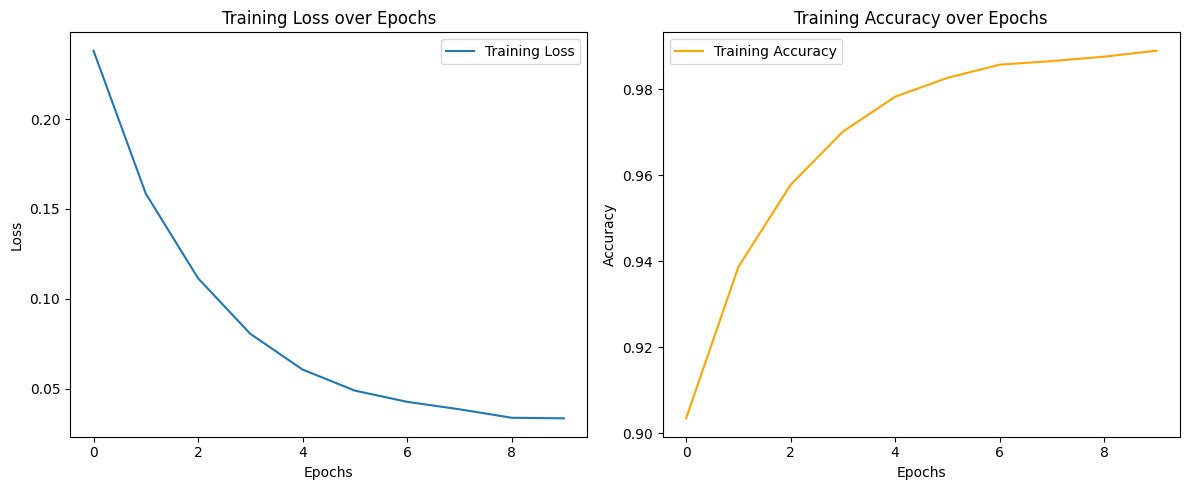

In [108]:
plt.figure(figsize=(12, 5))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='orange')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [109]:
model.eval()
correct = 0
total = 0

with torch.no_grad():  
    for batch_idx, (data, labels) in enumerate(test_loader):
        data, labels = data.to(device), labels.to(device)

        outputs = model(data)
        outputs = outputs.squeeze(1)  # Bce loss için

        predicted = (outputs >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 98.11%
